              Silver Thickness (nm)  Polymer Thickness (nm)  Period (nm)
Ground truth                  22.00                  297.00       497.00
Tandem                        22.22                  297.47       497.75
cVAE_1                        22.83                  296.07       498.72
cVAE_2                        22.75                  297.08       498.63
cVAE_3                        22.89                  295.71       498.76
cVAE_4                        22.80                  296.19       498.73
cVAE_5                        22.84                  295.29       498.71


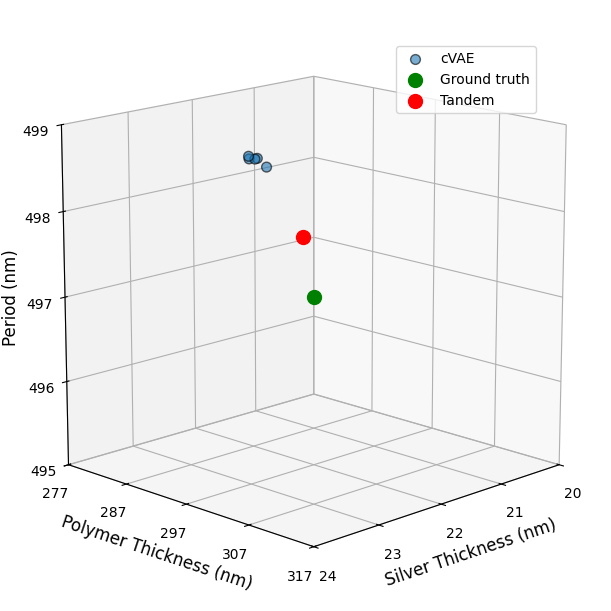

In [1]:
#To show the prediction of the structural parameters of our own data using trained Tandem and CVAE models
#3d plot of tandem and cVAE predictions on clean and noisy data 
import os
import cv2
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

import sys
sys.path.append('/path to codes/')
from Models import Autoencoder, cVAEtoStructureMH, StructureToLatent, LatenttoStructureMH, TandemNetwork
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def min_max_scaler(values, min_values, max_values):
    return [(value - min_val) / (max_val - min_val) for value, min_val, max_val in zip(values, min_values, max_values)]

def revert_min_max_scaler(normalized_value, min_value, max_value):
    return normalized_value * (max_value - min_value) + min_value

min_values = [10, 0, 280]  
max_values = [100, 1500, 550]  

autoencoder_model_path = "/path to autoencoder model/autoencoder_model_128_noise.pth"
ae_model = Autoencoder(latent_dim=128)
ae_model.load_state_dict(torch.load(autoencoder_model_path, map_location=device, weights_only=True))
ae_model.to(device)
ae_model.eval()
def get_latent_vector(ae_model, reflection_tensor):
    with torch.no_grad():
        _, c_latent = ae_model(reflection_tensor)
    return c_latent

def load_structure_to_latent_model(model_path, input_dim=3, output_dim=128, device='cpu'):
    model = StructureToLatent(input_dim=input_dim, output_dim=output_dim)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()
    return model

def load_tandem_model(model_path, device='cpu'):
    forward_model = load_structure_to_latent_model(r"/path to forward model/Forward_model_Strtolatent_optuna_NoisyAE.pth", device=device)
    inverse_model = LatenttoStructureMH(input_dim=128, output_dim=3).to(device)
    tandem_model = TandemNetwork(forward_model, inverse_model)
    tandem_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    return tandem_model

def predict_and_reconstruct(latent_vector, model, device='cpu'):
    model.eval()
    with torch.no_grad():
        predicted_structure = model.pred(latent_vector)    
    predicted_structure = predicted_structure.cpu().numpy()
    return predicted_structure


for fold in range(1,2):
    model = cVAEtoStructureMH(latent_dim=32,encoder_dropout=0.1,decoder_dropout=0.1).to(device)
    model.load_state_dict(torch.load(f"/path to cVAE model/cVAE-AE_model_fold_{fold}_optuna_MH.pth", map_location="cpu", weights_only=True))
    model.eval()

    Tmodel = load_tandem_model(rf"/path to tandem model/Tandem_model_fold_{fold}_MH.pth", device=device)
    Tmodel.eval()

    actual_all = []
    predicted_all = []
    for i in range(6, 7):
        #to show the real structural parameters for comparison with the predictions. 
        #For your own data that you don't know the ground truth there is next code to be used
        structure = pd.read_csv(rf"/path to data/Structure_{i}.csv", header=None, skiprows=1)
        real_structure = structure.values.squeeze()
        # structure_data = np.array([min_max_scaler(row, min_values, max_values) for _, row in structure.iterrows()], dtype=np.float32)

        reflection = pd.read_csv(rf"/path to data/Reflection_TM_{i}.csv", header=None)
        reflection = reflection.iloc[1:, 1:].astype(float)
        reflection = reflection.values
        reflection_tensor = torch.tensor(reflection, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  
        c_latent = get_latent_vector(ae_model, reflection_tensor)
        
        with torch.no_grad():
            pred_clean = predict_and_reconstruct(c_latent, Tmodel, device=device)
        pred_clean = np.array(pred_clean)
        denorm_Tpred = [revert_min_max_scaler(pred_clean.flatten()[i], min_values[i], max_values[i]) for i in range(3)]
        denorm_Tpred = np.array(denorm_Tpred, dtype=float).tolist()
        
        generated_structures = []
        for _ in range(0,5):
            latent_dim = model.fc_mu.out_features  
            z = torch.randn(1, latent_dim).to(device)
            with torch.no_grad():
                x_gen = model.decode(z, c_latent)
                x_gen_np = x_gen.squeeze(0).detach().cpu().numpy()
                
            pred_structure = [revert_min_max_scaler(x_gen_np[i], min_values[i], max_values[i]) for i in range(3)]
            denorm_cVAEpred = np.array(pred_structure, dtype=float).tolist()
            generated_structures.append(pred_structure)
            
        denorm_structures = np.array(generated_structures)

        fig = plt.figure(figsize=(8,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=15, azim=45)  
        ax.set_box_aspect((1, 1, 1))
        ax.scatter(denorm_structures[:, 0], denorm_structures[:, 1], denorm_structures[:, 2], alpha=0.6, s=50, edgecolor='k', label='cVAE')
        ax.scatter(structure[0], structure[1], structure[2], color='green', s=100, label='Ground truth')
        ax.scatter(denorm_Tpred[0], denorm_Tpred[1], denorm_Tpred[2], color='red', s=100, label='Tandem')
        ax.set_xlabel("Silver Thickness (nm)", fontsize=12)
        ax.set_ylabel("Polymer Thickness (nm)", fontsize=12)
        ax.zaxis.set_rotate_label(False)
        ax.set_zlabel("Period (nm)", fontsize=12, rotation=90)
        ax.set_xlim([np.array(structure[0])-2, np.array(structure[0])+2])
        ax.set_ylim([np.array(structure[1])-20, np.array(structure[1])+20])
        ax.set_zlim([np.array(structure[2])-2, np.array(structure[2])+2])
        ax.set_xticks(np.arange(structure[0].item()-2, structure[0].item()+2 + 1, 1))
        ax.set_yticks(np.arange(structure[1].item()-20, structure[1].item()+20 + 1, 10))
        ax.set_zticks(np.arange(structure[2].item()-2, structure[2].item()+2 + 1, 1))  
        ax.zaxis.labelpad = 3.0 
        # plt.tight_layout()
        ax.legend(loc='upper right', bbox_to_anchor=(0.9, 0.95))
        plt.savefig('Predictions.png', dpi=600)

        param_names = ["Silver Thickness (nm)", "Polymer Thickness (nm)", "Period (nm)"]
        gt = np.asarray(real_structure).reshape(1, 3)
        tandem = np.asarray(denorm_Tpred, dtype=float).reshape(1, 3)
        cvae = np.asarray(denorm_structures, dtype=float)
        all_rows = np.vstack([gt, tandem, cvae])
        
        row_index = ["Ground truth", "Tandem"] + [f"cVAE_{k+1}" for k in range(cvae.shape[0])]
        df_out = pd.DataFrame(all_rows, columns=param_names, index=row_index)
        df_out_2 = df_out.round(2)
        print(df_out_2.to_string())

        #predictions are being saved in a csv file
        out_csv = f"S{i}_structures.csv"  
        df_out.to_csv(out_csv, index_label="Row", float_format="%.2f")
        plt.show()

In [ ]:
#to be used by the users to have predictions and plots - predictions are saved in a .csv file 
#Prediction of the structural parameters using trained Tandem and CVAE models
#3d plot of tandem and cVAE predictions on clean and noisy data 
import os
import cv2
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

import sys
sys.path.append('/path to codes/')
from Models import Autoencoder, cVAEtoStructureMH, StructureToLatent, LatenttoStructureMH, TandemNetwork
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def min_max_scaler(values, min_values, max_values):
    return [(value - min_val) / (max_val - min_val) for value, min_val, max_val in zip(values, min_values, max_values)]

def revert_min_max_scaler(normalized_value, min_value, max_value):
    return normalized_value * (max_value - min_value) + min_value

min_values = [10, 0, 280]  
max_values = [100, 1500, 550]  

autoencoder_model_path = "/path to autoencoder model/autoencoder_model_128_noise.pth"
ae_model = Autoencoder(latent_dim=128)
ae_model.load_state_dict(torch.load(autoencoder_model_path, map_location=device, weights_only=True))
ae_model.to(device)
ae_model.eval()
def get_latent_vector(ae_model, reflection_tensor):
    with torch.no_grad():
        _, c_latent = ae_model(reflection_tensor)
    return c_latent

def load_structure_to_latent_model(model_path, input_dim=3, output_dim=128, device='cpu'):
    model = StructureToLatent(input_dim=input_dim, output_dim=output_dim)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()
    return model

def load_tandem_model(model_path, device='cpu'):
    forward_model = load_structure_to_latent_model(r"/path to forward model/Forward_model_Strtolatent_optuna_NoisyAE.pth", device=device)
    inverse_model = LatenttoStructureMH(input_dim=128, output_dim=3).to(device)
    tandem_model = TandemNetwork(forward_model, inverse_model)
    tandem_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    return tandem_model

def predict_and_reconstruct(latent_vector, model, device='cpu'):
    model.eval()
    with torch.no_grad():
        predicted_structure = model.pred(latent_vector)    
    predicted_structure = predicted_structure.cpu().numpy()
    return predicted_structure


for fold in range(1,2):
    model = cVAEtoStructureMH(latent_dim=32,encoder_dropout=0.1,decoder_dropout=0.1).to(device)
    model.load_state_dict(torch.load(f"/path to cVAE model/cVAE-AE_model_fold_{fold}_optuna_MH.pth", map_location="cpu", weights_only=True))
    model.eval()

    Tmodel = load_tandem_model(rf"/path to tandem model/Tandem_model_fold_{fold}_MH.pth", device=device)
    Tmodel.eval()

    actual_all = []
    predicted_all = []
    for i in range(6, 7):
        reflection = pd.read_csv(rf"/path to data/Reflection_TM_{i}.csv", header=None)
        reflection = reflection.iloc[1:, 1:].astype(float)
        reflection = reflection.values
        reflection_tensor = torch.tensor(reflection, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  
        c_latent = get_latent_vector(ae_model, reflection_tensor)
        
        with torch.no_grad():
            pred_clean = predict_and_reconstruct(c_latent, Tmodel, device=device)
        pred_clean = np.array(pred_clean)
        denorm_Tpred = [revert_min_max_scaler(pred_clean.flatten()[i], min_values[i], max_values[i]) for i in range(3)]
        denorm_Tpred = np.array(denorm_Tpred, dtype=float).tolist()
        
        generated_structures = []
        for _ in range(0,5):
            latent_dim = model.fc_mu.out_features  
            z = torch.randn(1, latent_dim).to(device)
            with torch.no_grad():
                x_gen = model.decode(z, c_latent)
                x_gen_np = x_gen.squeeze(0).detach().cpu().numpy()
                
            pred_structure = [revert_min_max_scaler(x_gen_np[i], min_values[i], max_values[i]) for i in range(3)]
            denorm_cVAEpred = np.array(pred_structure, dtype=float).tolist()
            generated_structures.append(pred_structure)
            
        denorm_structures = np.array(generated_structures)

        fig = plt.figure(figsize=(8,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=15, azim=45)  
        ax.set_box_aspect((1, 1, 1))
        ax.scatter(denorm_structures[:, 0], denorm_structures[:, 1], denorm_structures[:, 2], alpha=0.6, s=50, edgecolor='k', label='cVAE')
        ax.scatter(denorm_Tpred[0], denorm_Tpred[1], denorm_Tpred[2], color='red', s=100, label='Tandem')
        ax.set_xlabel("Silver Thickness (nm)", fontsize=12)
        ax.set_ylabel("Polymer Thickness (nm)", fontsize=12)
        ax.zaxis.set_rotate_label(False)
        ax.set_zlabel("Period (nm)", fontsize=12, rotation=90)
        ax.zaxis.labelpad = 3.0 
        # plt.tight_layout()
        ax.legend(loc='upper right', bbox_to_anchor=(0.9, 0.95))
        plt.savefig('Predictions.png', dpi=600)

        param_names = ["Silver Thickness (nm)", "Polymer Thickness (nm)", "Period (nm)"]
        tandem = np.asarray(denorm_Tpred, dtype=float).reshape(1, 3)
        cvae = np.asarray(denorm_structures, dtype=float)
        all_rows = np.vstack([tandem, cvae])
        
        row_index = ["Tandem"] + [f"cVAE_{k+1}" for k in range(cvae.shape[0])]
        df_out = pd.DataFrame(all_rows, columns=param_names, index=row_index)
        df_out_2 = df_out.round(2)
        print(df_out_2.to_string())

        #predictions are being saved in a csv file
        out_csv = f"S{i}_structures.csv"  
        df_out.to_csv(out_csv, index_label="Row", float_format="%.2f")
        plt.show()